In [1]:
import os
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve, auc,
    balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score
)

import matplotlib.pyplot as plt
from IPython.display import display

# =========================
#       CONFIG
# =========================
INPUT_SHAPE   = (13, 40, 1)
BATCH_SIZE    = 128
EPOCHS        = 20
LEARNING_RATE = 1e-3
SEED          = 42

# ======= POINT THESE TO YOUR CLASS FOLDERS =======
# Example (binary):
CLASS_DIRS = [
    ("drone",    r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Drone Dataset/MFCC Drone Dataset"),
    ("no_drone", r"/home/destrox-907/Husnian_FYP/Dataset/MFCC Noise Dataset/MFCC Noise Dataset"),
]
# Example (3-class): add more tuples, e.g. ("membo", "…"), ("bebop", "…"), ("noise", "…")

# =========================
#   PATHS & LABELS
# =========================
def collect_npy_paths(root_dir):
    paths = []
    for r, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(".npy"):
                paths.append(os.path.join(r, f))
    return paths

all_paths = []
all_labels_str = []
for label_name, folder in CLASS_DIRS:
    p = collect_npy_paths(folder)
    all_paths.extend(p)
    all_labels_str.extend([label_name]*len(p))

all_paths      = np.array(all_paths)
all_labels_str = np.array(all_labels_str)
print(f"[INFO] Total files: {len(all_paths)}")
for lbl in sorted(set(all_labels_str)):
    print(f"  - {lbl}: {(all_labels_str==lbl).sum()}")

# Encode labels -> integers -> one-hot
le = LabelEncoder()
y_int = le.fit_transform(all_labels_str)
num_classes = len(le.classes_)
y_onehot = tf.keras.utils.to_categorical(y_int, num_classes=num_classes)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    all_paths, y_onehot, test_size=0.2, random_state=SEED, stratify=y_int
)

print(f"[INFO] Classes: {list(le.classes_)}  (num_classes={num_classes})")
print(f"[INFO] Train: {len(X_train)} | Test: {len(X_test)}")





2025-09-11 08:15:34.448082: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 08:15:34.647528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-11 08:15:35.475878: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[INFO] Total files: 390897
  - drone: 268268
  - no_drone: 122629
[INFO] Classes: [np.str_('drone'), np.str_('no_drone')]  (num_classes=2)
[INFO] Train: 312717 | Test: 78180


In [2]:

# =========================
#   DATA PIPELINE (tf.data)
# =========================
def npy_loader(path):
    """Load one (13,40,1) MFCC tile from .npy path."""
    p = path.decode("utf-8")
    try:
        arr = np.load(p)
        arr = np.asarray(arr, dtype="float32")
        arr = arr.reshape(INPUT_SHAPE)  # enforce shape
        return arr
    except Exception as e:
        print(f"[WARN] Failed to load {p}: {e}")
        return np.zeros(INPUT_SHAPE, dtype="float32")

def tf_load(path, label):
    x = tf.numpy_function(npy_loader, [path], Tout=tf.float32)
    x = tf.ensure_shape(x, INPUT_SHAPE)
    return x, label

def make_dataset(paths, labels, batch=BATCH_SIZE, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(8192, reshuffle_each_iteration=True, seed=SEED)
    ds = ds.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
test_ds  = make_dataset(X_test,  y_test,  training=False)

I0000 00:00:1757560550.947407    5335 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21839 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1757560550.948705    5335 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22148 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:05:00.0, compute capability: 8.9


In [3]:
# =========================
#   SAME CNN AS BEFORE
# =========================
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax"),
])

cnn_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

cnn_model.summary()

# =========================
#       TRAIN & EVAL
# =========================
history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS
)

test_loss, test_acc = cnn_model.evaluate(test_ds, verbose=0)
print(f"\nCNN Test Accuracy: {test_acc:.4f}")

/home/destrox-907/Husnian_FYP/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 38, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 19, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 19, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 17, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,738 (331.01 KB)

 Trainable params: 84,738 (331.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-09-11 08:15:54.728447: I external/local_xla/xla/service/service.cc:163] XLA service 0x748ee801d440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-11 08:15:54.728460: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-11 08:15:54.728462: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-11 08:15:54.777281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-11 08:15:54.883256: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-09-11 08:15:54.972242: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints

  15/2444 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.6089 - loss: 6.0289

I0000 00:00:1757560557.110291    6091 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2444/2444 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8573 - loss: 0.5032

2025-09-11 08:16:46.109149: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-11 08:16:46.299191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 12 bytes spill stores, 12 bytes spill loads

2025-09-11 08:16:46.308347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 12 bytes spill stores, 12 bytes spill loads

2025-09-11 08:16:46.377392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 16 bytes

2444/2444 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0.9037 - loss: 0.2500 - val_accuracy: 0.9484 - val_loss: 0.1256
Epoch 2/20
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9489 - loss: 0.1271 - val_accuracy: 0.9642 - val_loss: 0.0974
Epoch 3/20
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.9580 - loss: 0.1069 - val_accuracy: 0.9706 - val_loss: 0.0812
Epoch 4/20
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.9627 - loss: 0.0964 - val_accuracy: 0.9764 - val_loss: 0.0638
Epoch 5/20
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.9665 - loss: 0.0883 - val_accuracy: 0.9779 - val_loss: 0.0602
Epoch 6/20
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.9686 - loss: 0.0837 - val_accuracy: 0.9731 - val_loss: 0.0717
Epoch 7/20
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9697 - loss: 0.0802 - val_accuracy: 0.9790 - val_loss: 0.0565
Epoch 8/20
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.9711 - loss: 0.07

In [4]:
cnn_model.save("cnn_orignal_data02.keras")

2025-09-11 08:31:37.394258: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


611/611 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


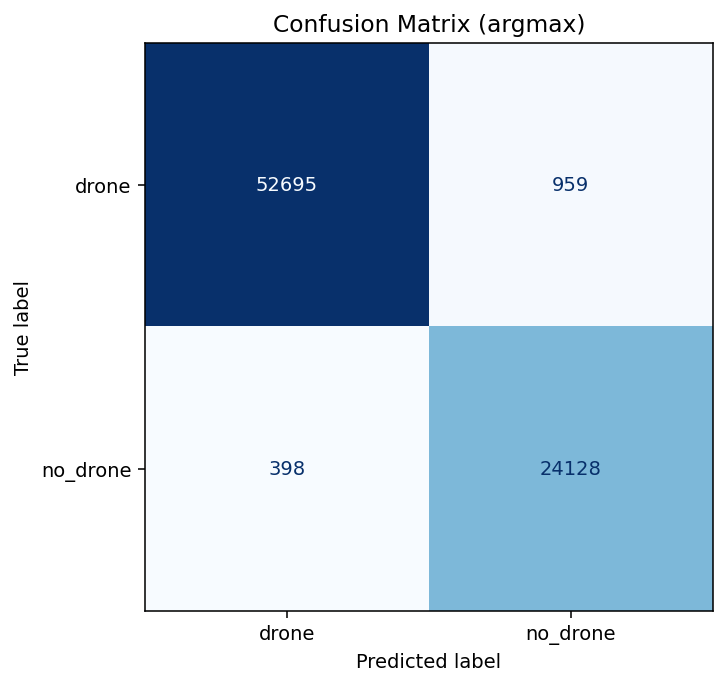

Confusion Matrix (rows=true, cols=pred):
[[52695   959]
 [  398 24128]]

Classification Report (argmax):
              precision    recall  f1-score   support

       drone       0.99      0.98      0.99     53654
    no_drone       0.96      0.98      0.97     24526

    accuracy                           0.98     78180
   macro avg       0.98      0.98      0.98     78180
weighted avg       0.98      0.98      0.98     78180


=== Summary (argmax) ===
Accuracy                : 0.9826
Balanced Accuracy       : 0.9829
Precision/Recall/F1 (micro)   : 0.9826 / 0.9826 / 0.9826
Precision/Recall/F1 (macro)   : 0.9771 / 0.9829 / 0.9800
Precision/Recall/F1 (weighted): 0.9829 / 0.9826 / 0.9827
MCC                      : 0.9601
Cohen's kappa            : 0.9599


In [5]:
# =========================
#  PREDICT & METRICS (“Everything”)
# =========================
# Ground truth (int labels) for metrics
y_true_int = np.argmax(np.vstack([y for _, y in test_ds.unbatch()]), axis=1)

# Predicted probabilities & labels
probs = cnn_model.predict(test_ds, verbose=1)  # shape: (N, num_classes)
y_pred_int_argmax = np.argmax(probs, axis=1)

# ---- Confusion Matrix (argmax) ----
def plot_cm_inline(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    fig, ax = plt.subplots(figsize=(6, 5), dpi=140)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()
    display(fig)
    plt.close(fig)
    return cm

cm_argmax = plot_cm_inline(y_true_int, y_pred_int_argmax, le.classes_,
                           title="Confusion Matrix (argmax)")

print("Confusion Matrix (rows=true, cols=pred):")
print(cm_argmax)
print("\nClassification Report (argmax):")
print(classification_report(y_true_int, y_pred_int_argmax, target_names=le.classes_))

# ---- Scalar metrics from argmax predictions ----
acc   = accuracy_score(y_true_int, y_pred_int_argmax)
prec_micro  = precision_score(y_true_int, y_pred_int_argmax, average="micro", zero_division=0)
rec_micro   = recall_score(y_true_int,    y_pred_int_argmax, average="micro", zero_division=0)
f1_micro    = f1_score(y_true_int,       y_pred_int_argmax, average="micro", zero_division=0)

prec_macro  = precision_score(y_true_int, y_pred_int_argmax, average="macro", zero_division=0)
rec_macro   = recall_score(y_true_int,    y_pred_int_argmax, average="macro", zero_division=0)
f1_macro    = f1_score(y_true_int,       y_pred_int_argmax, average="macro", zero_division=0)

prec_weight = precision_score(y_true_int, y_pred_int_argmax, average="weighted", zero_division=0)
rec_weight  = recall_score(y_true_int,    y_pred_int_argmax, average="weighted", zero_division=0)
f1_weight   = f1_score(y_true_int,       y_pred_int_argmax, average="weighted", zero_division=0)

bal_acc     = balanced_accuracy_score(y_true_int, y_pred_int_argmax)
mcc         = matthews_corrcoef(y_true_int, y_pred_int_argmax)
kappa       = cohen_kappa_score(y_true_int, y_pred_int_argmax)

print("\n=== Summary (argmax) ===")
print(f"Accuracy                : {acc:.4f}")
print(f"Balanced Accuracy       : {bal_acc:.4f}")
print(f"Precision/Recall/F1 (micro)   : {prec_micro:.4f} / {rec_micro:.4f} / {f1_micro:.4f}")
print(f"Precision/Recall/F1 (macro)   : {prec_macro:.4f} / {rec_macro:.4f} / {f1_macro:.4f}")
print(f"Precision/Recall/F1 (weighted): {prec_weight:.4f} / {rec_weight:.4f} / {f1_weight:.4f}")
print(f"MCC                      : {mcc:.4f}")
print(f"Cohen's kappa            : {kappa:.4f}")
